# House Prices – Advanced Regression Project

In diesem Notebook entwickle ich ein Regressionsmodell zur Vorhersage von Immobilienpreisen. 
Der Fokus liegt auf einer vollständigen ML‑Pipeline mit EDA, Feature Engineering, Modellvergleich, 
SHAP‑Interpretation und Residuenanalyse.


## **Daten laden und Überblick**

In [10]:
import pandas as pd 
import numpy as np 

df = pd.read_csv("C:/Users/Carlsson Arlt/VS Code/HousePrices/data/train.csv")
df.head() 
df.info() 
df = df.drop(columns=['Id'])
df.isna().sum().sort_values(ascending=False).head(20)

<class 'pandas.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   str    
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   str    
 6   Alley          91 non-null     str    
 7   LotShape       1460 non-null   str    
 8   LandContour    1460 non-null   str    
 9   Utilities      1460 non-null   str    
 10  LotConfig      1460 non-null   str    
 11  LandSlope      1460 non-null   str    
 12  Neighborhood   1460 non-null   str    
 13  Condition1     1460 non-null   str    
 14  Condition2     1460 non-null   str    
 15  BldgType       1460 non-null   str    
 16  HouseStyle     1460 non-null   str    
 17  OverallQual    1460 non-null   int64  
 18  OverallCond    1460

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageQual        81
GarageType        81
GarageFinish      81
GarageCond        81
GarageYrBlt       81
BsmtExposure      38
BsmtFinType2      38
BsmtQual          37
BsmtFinType1      37
BsmtCond          37
MasVnrArea         8
Electrical         1
BldgType           0
dtype: int64

### Datenüberblick

Hier werden die Daten geladen und eine rster Überblick über Struktur, Datentypen und fehlende Werte gegeben.

## **Explorative Datenanalyse (EDA)**

### Zielvariable

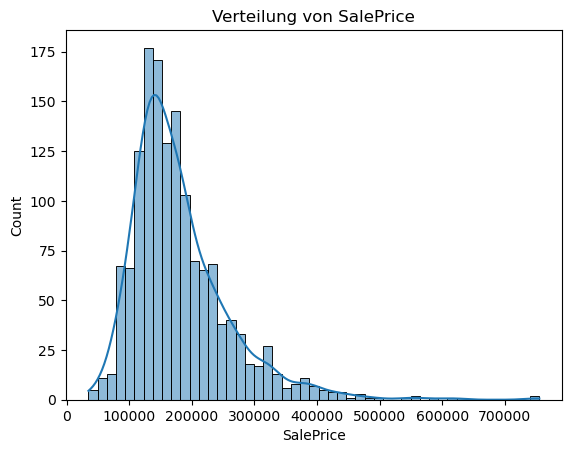

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(df['SalePrice'], kde=True)
plt.title("Verteilung von SalePrice")
plt.show()

### Log-Transformation

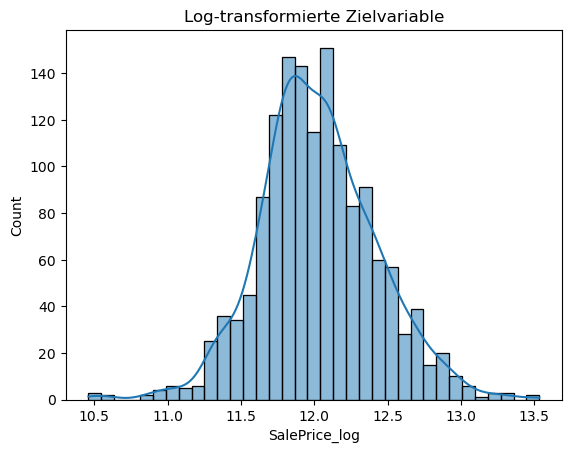

In [12]:
df['SalePrice_log'] = np.log1p(df['SalePrice'])
sns.histplot(df['SalePrice_log'], kde=True)
plt.title("Log-transformierte Zielvariable")
plt.show()

### Korrelationen

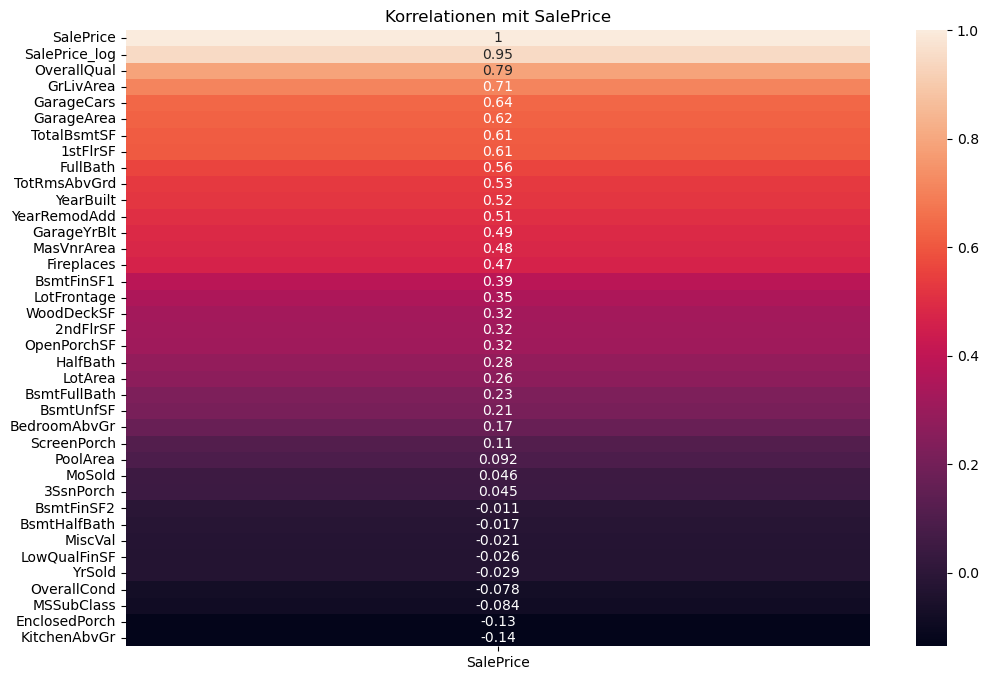

In [15]:
plt.figure(figsize=(12,8))
sns.heatmap(df.corr(numeric_only=True)['SalePrice'].sort_values(ascending=False).to_frame(), annot=True)
plt.title("Korrelationen mit SalePrice")
plt.show()

Die wichtigsten Einflussfaktoren werden visuell untersucht, um Muster und Zusammhänge zu erkennen.

## **Feature Engineering**

In [16]:
df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']
df['HouseAge'] = df['YrSold'] - df['YearBuilt']
df['RemodAge'] = df['YrSold'] - df['YearRemodAdd']
df['QualityIndex'] = df['OverallQual'] * df['OverallCond']
df['TotalBath'] = df['FullBath'] + 0.5 * df['HalfBath'] + df['BsmtFullBath'] + 0.5 * df['BsmtHalfBath']
df['PorchSF'] = df['OpenPorchSF'] + df['EnclosedPorch'] + df['3SsnPorch'] + df['ScreenPorch']
df['GarageScore'] = df['GarageCars'] * df['GarageArea']

Es wurden mehrere neue Features erstellt, welche auf Domain-Wissen und Kaggle-Best-Pratices basieren.

## **Preprocessing**
- Missing Values
- One-Hot_Encoding
- Train/Test-Split

In [18]:
# Kategorien, bei denen NaN bedeutet: Feature existiert NICHT
cols_none = ['PoolQC', 'Alley', 'Fence', 'MiscFeature', 'FireplaceQu']
df[cols_none] = df[cols_none].fillna('None')

# Numerische Features, bei denen NaN = 0 sinnvoll ist
cols_zero = ['GarageArea', 'GarageCars', 'TotalBsmtSF', 'BsmtFinSF1']
df[cols_zero] = df[cols_zero].fillna(0)

# Kategorien, bei denen NaN = häufigster Wert (Mode)
df['MasVnrType'] = df['MasVnrType'].fillna(df['MasVnrType'].mode()[0])
df['Electrical'] = df['Electrical'].fillna(df['Electrical'].mode()[0])

# LotFrontage abhängig vom Stadtteil (Neighborhood) imputieren
df['LotFrontage'] = df.groupby('Neighborhood')['LotFrontage'].transform(
    lambda x: x.fillna(x.median())
)

# Weitere sinnvolle Imputationen
df['GarageYrBlt'] = df['GarageYrBlt'].fillna(0)
df['MasVnrArea'] = df['MasVnrArea'].fillna(0)


# Ordinale Kategorien in Zahlen umwandeln
qual_map = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1}

df['ExterQual'] = df['ExterQual'].map(qual_map)
df['KitchenQual'] = df['KitchenQual'].map(qual_map)


# One-Hot-Encoding für alle übrigen kategorialen Variablen
df = pd.get_dummies(df, drop_first=True)


# Train/Test-Split
from sklearn.model_selection import train_test_split

X = df.drop(['SalePrice', 'SalePrice_log'], axis=1)
y = df['SalePrice_log']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## **Modellvergleich**
Es wurden 3 Gradient-Boosting-Modelle trainiert und verglichen: XGBoost, LightGBM und CatBoost.
Alle Modelle wurden mit ähnlichen Hyperparametern konfiguriert, um einen fairen Vergleich zu ermöglichen.

Die Bewertung erfolgte anhand von: 
- **RMSE** (Root Mean Squared Error) 
- **R²** (Bestimmtheitsmaß)

CatBoost erzielte die beste Performance und wurde daher als finales Modell ausgewählt.
### Evaluationsfunktion

In [19]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

def evaluate(model_name, y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"{model_name}: RMSE = {rmse:.4f}, R² = {r2:.4f}")
    return rmse, r2

### XGBoost

In [20]:
from xgboost import XGBRegressor

xgb = XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

rmse_xgb, r2_xgb = evaluate("XGBoost", y_test, y_pred_xgb)

XGBoost: RMSE = 0.1349, R² = 0.9024


### LightGBM

In [22]:
from lightgbm import LGBMRegressor

lgbm = LGBMRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=-1,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    verbosity=0
)

lgbm.fit(X_train, y_train)
y_pred_lgbm = lgbm.predict(X_test)

rmse_lgbm, r2_lgbm = evaluate("LightGBM", y_test, y_pred_lgbm)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
LightGBM: RMSE = 0.1386, R² = 0.8971


### CatBoost

In [23]:
from catboost import CatBoostRegressor

cat = CatBoostRegressor(
    iterations=2000,
    learning_rate=0.03,
    depth=6,
    loss_function='RMSE',
    verbose=False,
    random_seed=42
)

cat.fit(X_train, y_train)
y_pred_cat = cat.predict(X_test)

rmse_cat, r2_cat = evaluate("CatBoost", y_test, y_pred_cat)

CatBoost: RMSE = 0.1315, R² = 0.9073


In [24]:
results = pd.DataFrame({
    "Modell": ["XGBoost", "LightGBM", "CatBoost"],
    "RMSE": [rmse_xgb, rmse_lgbm, rmse_cat],
    "R²": [r2_xgb, r2_lgbm, r2_cat]
})

results

,Modell,RMSE,R²
0,XGBoost,0.134935,0.902432
1,LightGBM,0.138561,0.897117
2,CatBoost,0.131493,0.907346


## **SHAP-Analyse**
Um zu verstehen, welche Features den größten Einfluss auf die Vorhersagen des Modells haben, wird SHAP (SHapley Additive exPlanations) verwendet. SHAP ermöglicht eine transparente Interpretation von Gradient-Boosting-Modellen und zeigt, welche Merkmale den Preis erhöhen oder senken. Die Analyse basiert auf dem finalen CatBoost-Modell.

c:\Users\Carlsson Arlt\.conda\envs\ds\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


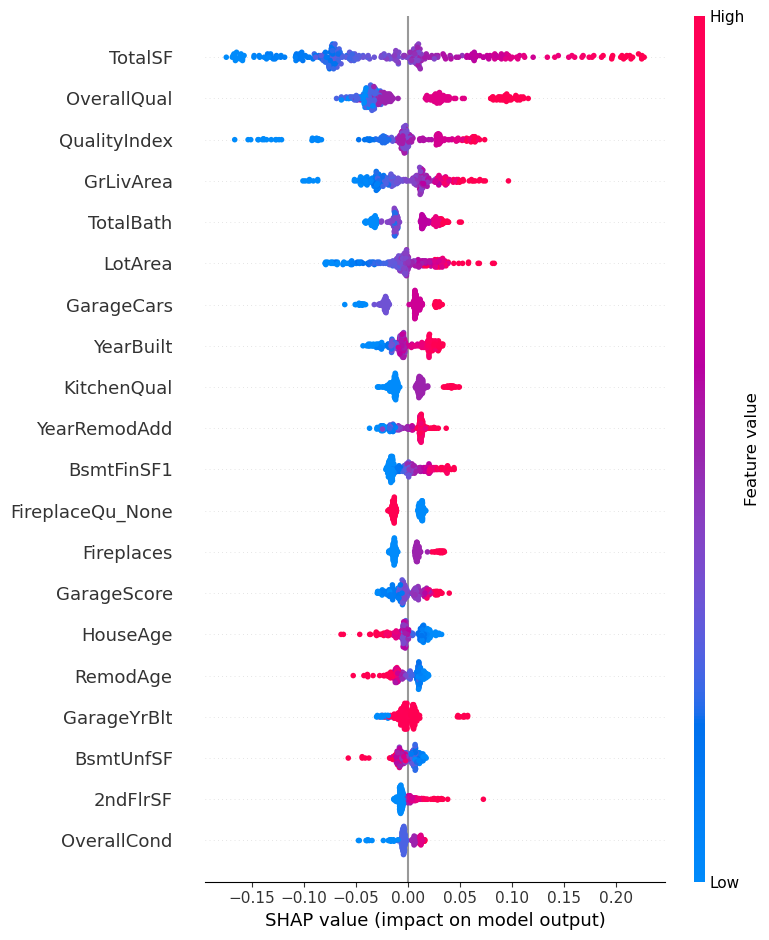

In [25]:
import shap

explainer = shap.TreeExplainer(cat)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test)

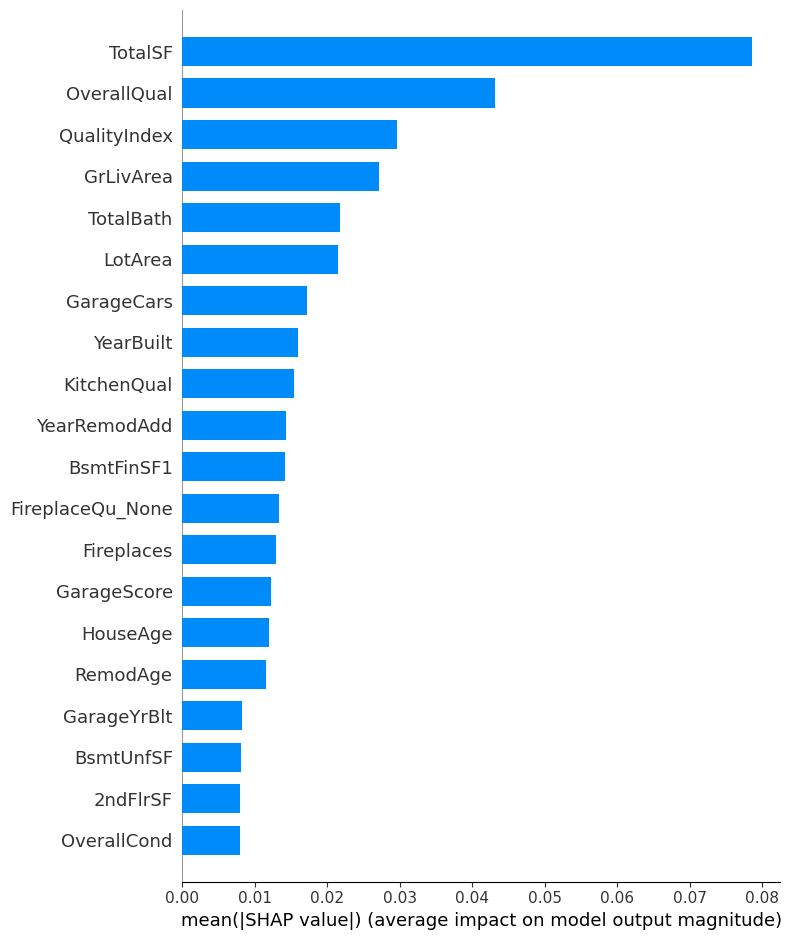

In [26]:
shap.summary_plot(shap_values, X_test, plot_type="bar")